In [32]:
%load_ext autoreload
%autoreload 2
import sys
import torch


sys.path.insert(0,'/home/aw1223/ip/agile')

from sdk.ample import Ample

from torch_geometric.datasets import FakeDataset #TODO remove
from sdk.models.models import MLP_Model,Interaction_Net_Model,GCN_Model

from torch_geometric.data import Data


class Graphcast(torch.nn.Module):
    def __init__(self, in_channels=32, out_channels=32, layer_count=1, hidden_dimension=32, precision = torch.float32):
        super().__init__()
        self.precision = precision
        self.layers = torch.nn.ModuleList()
       
        self.grid_mesh_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.grid_mesh_embedder.name  = 'grid_mesh_embedder'
        self.layers.append(self.grid_mesh_embedder) 

        self.g2m_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.g2m_embedder.name  = 'g2m_embedder'
        self.layers.append(self.g2m_embedder) 

        self.g2m_int_net = Interaction_Net_Model()
        self.g2m_int_net.name  = 'g2m_int_net'
        self.layers.append(self.g2m_int_net) 

        self.m2m_embedder = MLP_Model(in_channels, hidden_dimension) 
        self.m2m_embedder.name  = 'm2m_embedder'
        self.layers.append(self.m2m_embedder) 

        self.m2m_int_net = Interaction_Net_Model()
        self.m2m_int_net.name  = 'm2m_int_net'
        self.layers.append(self.m2m_int_net) 
        

        self.m2g_int_net = Interaction_Net_Model()
        self.m2g_int_net.name  = 'm2m_int_net'
        self.layers.append(self.m2g_int_net) 
        
        for layer in self.layers:
            layer.to(self.precision)

    def forward(self,g2m_edge_attr,g2m_edge_index,grid_rep):
        outputs_model = []
        
        outputs_sub_model1,grid_emb = self.grid_mesh_embedder(grid_rep)
        
        outputs_sub_model2,g2m_emb = self.g2m_embedder(g2m_edge_attr)

        outputs_sub_model3,mesh_rep = self.g2m_int_net(grid_emb, g2m_edge_index, g2m_emb)
        
        # outputs_sub_model4,m2m_emb = self.m2m_embedder(g2m_edge_attr)

        outputs_sub_model5,mesh_rep = self.m2m_int_net(mesh_rep, g2m_edge_index,g2m_emb)

        outputs_sub_model6,grid_rep = self.m2g_int_net(mesh_rep, g2m_edge_index,g2m_emb)

        outputs_model = outputs_sub_model1 + outputs_sub_model2 + outputs_sub_model3 + outputs_sub_model5 + outputs_sub_model6 #+ outputs_sub_model4
        return outputs_model,grid_rep



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
model = Graphcast(32,32)

dataset = FakeDataset(
                        num_graphs=1, 
                        avg_num_nodes = 15,
                        avg_degree=3,
                        num_channels=32,
                        edge_dim=32
                    )[0]

#IMPORTANT: The order of the inputs in the forward function must match the order of the external inputs identified by the compiler
inputs = [dataset.edge_attr,dataset.edge_index,dataset.x]
# inputs = [dataset.x]

# inputs = [dataset.edge_index,dataset.x]
# print(*inputs)
# for input_data in inputs:
#     print(input_data.shape)
out = model(*inputs)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Rendering graph...


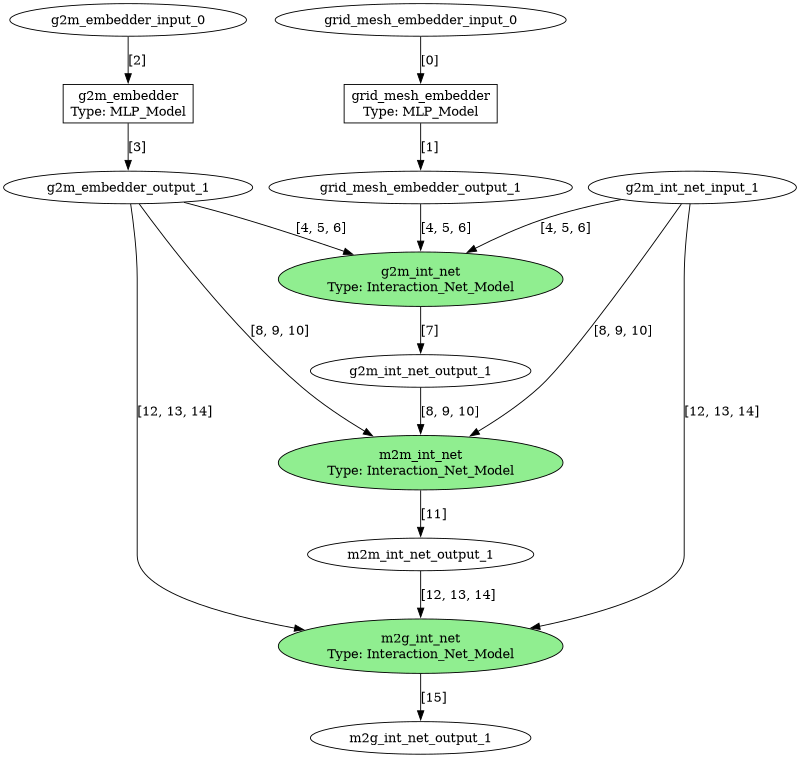

Ensure inputs match the following list {'g2m_embedder_input_0': None, 'g2m_int_net_input_1': None, 'grid_mesh_embedder_input_0': None}
-----layer---j 0 mlp_input_output_layer
-----layer---j 0 mlp_input_output_layer
-----layer---j 0 linear_src_embedder
-----layer---j 1 linear_edge_embedder
-----layer---j 2 linear_rx_embedder
-----layer---j 3 gcn_edge_update
-----layer---j 4 linear_rx_node_embedder
-----layer---j 5 gcn_rx_edge_aggr
-----layer---j 6 rx_node_update
-----layer---j 0 linear_src_embedder
-----layer---j 1 linear_edge_embedder
-----layer---j 2 linear_rx_embedder
-----layer---j 3 gcn_edge_update
-----layer---j 4 linear_rx_node_embedder
-----layer---j 5 gcn_rx_edge_aggr
-----layer---j 6 rx_node_update
-----layer---j 0 linear_src_embedder
-----layer---j 1 linear_edge_embedder
-----layer---j 2 linear_rx_embedder
-----layer---j 3 gcn_edge_update
-----layer---j 4 linear_rx_node_embedder
-----layer---j 5 gcn_rx_edge_aggr
-----layer---j 6 rx_node_update


2it [00:00, 15563.28it/s]
7it [00:00, 30268.17it/s]
2it [00:00, 21076.90it/s]
7it [00:00, 44552.55it/s]
2it [00:00, 22192.08it/s]
7it [00:00, 38733.68it/s]
2it [00:00, 21620.12it/s]
7it [00:00, 44756.29it/s]
/home/aw1223/anaconda3/envs/ample/lib/python3.11/site-packages/torch/jit/_trace.py:1088: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


In [34]:
import torch.nn.init as init

%load_ext autoreload
%autoreload 2
%pwd


ample = Ample(sim = True)

# Need weights to be initialized before calling to_device
model.to_device('ample',data=inputs) #Change 

In [35]:
out = model(*inputs)

Executing on AMPLE
cd /home/aw1223/ip/agile/hw/sim
==== Running command: cd /home/aw1223/ip/agile/hw/sim; make run_sim
make -f Makefile.modelsim run_sim
make[1]: Entering directory '/home/aw1223/ip/agile/hw/sim'
set -o pipefail; LIBPYTHON_LOC=/home/aw1223/anaconda3/envs/ample/lib/libpython3.11.so.1.0 MODULE=runner TESTCASE= TOPLEVEL="work.top_wrapper" \
GPI_EXTRA= TOPLEVEL_LANG=verilog \
 /mnt/applications/mentor/modelsim-2019.2/modelsim/modeltech/linux_x86_64/vsim -c -64 -l sim_build/modelsim.log -onfinish exit -do sim_build/../simulate_no_gui.do -quiet -suppress vsim-3015  -pli /home/aw1223/anaconda3/envs/ample/lib/python3.11/site-packages/cocotb/libs/libcocotbvpi_modelsim.so \
 \
work.work_opt \
 2>&1 | tee sim_build/simulate.log
/mnt/applications/mentor/modelsim-2019.2/modelsim/modeltech/linux_x86_64/vish: /mnt/applications/Xilinx/19.2/Vitis/2019.2/lib/lnx64.o/libxml2.so.2: no version information available (required by /lib64/libfontconfig.so.1)
/mnt/applications/mentor/modelsim-20

grid_x torch.Size([16, 32])
tensor([[0.3420, 0.6225, 0.4878, 0.1749, 0.9685, 0.3863, 0.0709, 0.0062, 0.4233,
         0.2548, 0.4217, 0.4284, 0.7635, 0.7951, 0.5015, 0.6809, 0.1579, 0.1813,
         0.7636, 0.7320, 0.4259, 0.3088, 0.2687, 0.1393, 0.6867, 0.8324, 0.3772,
         0.2996, 0.6334, 0.0010, 0.5124, 0.8793],
        [0.2367, 0.6705, 0.9185, 0.3385, 0.1802, 0.1029, 0.0084, 0.6117, 0.6572,
         0.5946, 0.8366, 0.6473, 0.7943, 0.6128, 0.1692, 0.9661, 0.6736, 0.5448,
         0.0995, 0.6800, 0.6910, 0.2981, 0.7329, 0.1342, 0.2857, 0.7087, 0.9651,
         0.6121, 0.9637, 0.7017, 0.6790, 0.8984],
        [0.2247, 0.1134, 0.4416, 0.1935, 0.3726, 0.4787, 0.9570, 0.1770, 0.7409,
         0.9481, 0.1929, 0.7826, 0.7631, 0.3194, 0.2080, 0.5561, 0.9718, 0.3601,
         0.3401, 0.6291, 0.7662, 0.6708, 0.9996, 0.0272, 0.4446, 0.6081, 0.9623,
         0.5223, 0.1159, 0.5647, 0.1812, 0.0589],
        [0.8602, 0.2528, 0.5772, 0.3508, 0.7655, 0.0382, 0.7798, 0.4270, 0.1949,
         0.1